# Assignment 4

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn
!pip install torch
!pip install transformers datasets
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from datasets import load_dataset
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import random
import warnings

In [ ]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed()

# Initial run was done on a macbook but this code is good for if you have an nvidia gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Task 1: AG News Data

In [ ]:
print("Loading AG News dataset...")
train_dataset = load_dataset('ag_news', split='train')
test_dataset = load_dataset('ag_news', split='test')
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Exploratory data analysis
print("\nDataset format:")
print(train_dataset[0])

Loading AG News dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Train dataset size: 120000
Test dataset size: 7600

Dataset format:
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


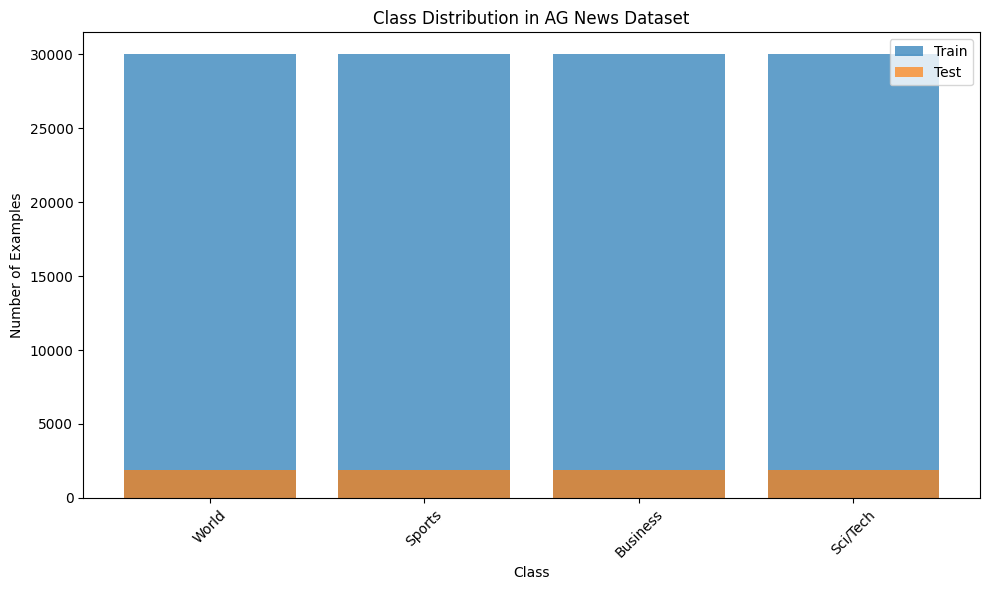

In [ ]:
# Get class distribution
train_labels = [example['label'] for example in train_dataset]
test_labels = [example['label'] for example in test_dataset]

label_names = ['World', 'Sports', 'Business', 'Sci/Tech']
train_label_counts = np.bincount(train_labels)
test_label_counts = np.bincount(test_labels)

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(label_names, train_label_counts, alpha=0.7, label='Train')
plt.bar(label_names, test_label_counts, alpha=0.7, label='Test')
plt.title('Class Distribution in AG News Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Display some examples from each class
print("\nExample from each class:")
for i, label in enumerate(label_names):
    example = next(ex for ex in train_dataset if ex['label'] == i)
    print(f"\nClass: {label}")
    print(f"Text: {example['text']}")


Example from each class:

Class: World
Text: Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.

Class: Sports
Text: Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminaries.

Class: Business
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Class: Sci/Tech
Text: 'Madden,' 'ESPN' Football Score in Different Ways (Reuters)

In [ ]:
# Create a validation set from the training set
print("\nSplitting training data into train and validation sets...")
train_texts = [example['text'] for example in train_dataset]
train_val_texts, val_texts, train_val_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=42, stratify=train_labels
)
print(f"Training set size: {len(train_val_texts)}")
print(f"Validation set size: {len(val_texts)}")


Splitting training data into train and validation sets...
Training set size: 108000
Validation set size: 12000


## Task 2: Loading pre-trained BERT

In [ ]:
print("\nLoading pre-trained BERT model...")
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = BertModel.from_pretrained("google-bert/bert-base-uncased")
bert_model.to(device)
bert_model.eval()  # Set to evaluation mode for feature extraction


Loading pre-trained BERT model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

## Task 3.1: Probing

In [ ]:
# Function to extract BERT embeddings
def extract_bert_embeddings(texts, strategy='cls'):
    embeddings = []

    with torch.no_grad():
        for text in tqdm(texts, desc=f"Extracting BERT embeddings ({strategy})"):
            # Tokenize and convert to tensors
            encoded_input = tokenizer(text, padding='max_length', truncation=True,
                                     max_length=128, return_tensors='pt')
            encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

            # Get BERT outputs
            outputs = bert_model(**encoded_input)
            last_hidden_state = outputs.last_hidden_state

            # Extract embeddings based on the strategy
            if strategy == 'cls':
                # Use [CLS] token embedding (first token)
                embedding = last_hidden_state[:, 0, :].cpu().numpy()
            elif strategy == 'first':
                # Use first token embedding (same as CLS for BERT)
                embedding = last_hidden_state[:, 0, :].cpu().numpy()
            elif strategy == 'last':
                # Use last non-padding token
                attention_mask = encoded_input['attention_mask']
                last_token_idx = torch.sum(attention_mask, dim=1) - 1
                batch_size = last_hidden_state.size(0)
                embedding = torch.stack([last_hidden_state[i, last_token_idx[i], :]
                                        for i in range(batch_size)]).cpu().numpy()
            elif strategy == 'mean':
                # Mean pooling - Take attention mask into account for averaging
                attention_mask = encoded_input['attention_mask'].unsqueeze(-1)
                token_embeddings = last_hidden_state * attention_mask
                sum_embeddings = torch.sum(token_embeddings, dim=1)
                sum_mask = torch.sum(attention_mask, dim=1)
                embedding = (sum_embeddings / sum_mask).cpu().numpy()

            embeddings.append(embedding[0])

    return np.array(embeddings)

In [ ]:
# Extract embeddings for validation set with different strategies
print("\nExtracting BERT embeddings for validation set...")
strategies = ['cls', 'first', 'last', 'mean']
val_embeddings = {}

for strategy in strategies:
    val_embeddings[strategy] = extract_bert_embeddings(val_texts[:1000], strategy)  # Using subset for efficiency
    print(f"Validation embeddings shape ({strategy}): {val_embeddings[strategy].shape}")


Extracting BERT embeddings for validation set...


Extracting BERT embeddings (cls): 100%|██████████| 1000/1000 [09:07<00:00,  1.83it/s]


Validation embeddings shape (cls): (1000, 768)


Extracting BERT embeddings (first): 100%|██████████| 1000/1000 [08:52<00:00,  1.88it/s]


Validation embeddings shape (first): (1000, 768)


Extracting BERT embeddings (last): 100%|██████████| 1000/1000 [08:42<00:00,  1.91it/s]


Validation embeddings shape (last): (1000, 768)


Extracting BERT embeddings (mean): 100%|██████████| 1000/1000 [08:49<00:00,  1.89it/s]

Validation embeddings shape (mean): (1000, 768)


In [ ]:
# Function to evaluate KNN for different values of k
def evaluate_knn(train_embeddings, train_labels, val_embeddings, val_labels, k_values=None):
    """
    Evaluate KNN classifier for different k values
    """
    if k_values is None:
        k_values = [1, 3, 5, 7, 9, 11, 13, 15]

    results = {}

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_embeddings, train_labels)
        val_preds = knn.predict(val_embeddings)
        accuracy = accuracy_score(val_labels, val_preds)
        results[k] = accuracy
        print(f"KNN (k={k}) accuracy: {accuracy:.4f}")

    return results

In [ ]:
# Extract embeddings for a smaller subset of training data (for efficiency)
print("\nExtracting BERT embeddings for a subset of training data...")
subset_size = 5000  # Using a subset for efficiency
train_val_texts_subset = train_val_texts[:subset_size]
train_val_labels_subset = train_val_labels[:subset_size]

# Extract embeddings for training subset
train_embeddings = {}
for strategy in strategies:
    train_embeddings[strategy] = extract_bert_embeddings(train_val_texts_subset, strategy)
    print(f"Training embeddings shape ({strategy}): {train_embeddings[strategy].shape}")


Extracting BERT embeddings for a subset of training data...


Extracting BERT embeddings (cls): 100%|██████████| 5000/5000 [43:55<00:00,  1.90it/s]


Training embeddings shape (cls): (5000, 768)


Extracting BERT embeddings (first): 100%|██████████| 5000/5000 [44:16<00:00,  1.88it/s]


Training embeddings shape (first): (5000, 768)


Extracting BERT embeddings (last): 100%|██████████| 5000/5000 [43:49<00:00,  1.90it/s]


Training embeddings shape (last): (5000, 768)


Extracting BERT embeddings (mean): 100%|██████████| 5000/5000 [43:34<00:00,  1.91it/s]

Training embeddings shape (mean): (5000, 768)


In [ ]:
# Evaluate KNN for different embedding strategies and k values
print("\nEvaluating KNN with different embedding strategies and k values...")
knn_results = {}
best_k_values = {}
best_accuracies = {}

for strategy in strategies:
    print(f"\nEvaluating KNN with '{strategy}' embeddings:")
    knn_results[strategy] = evaluate_knn(
        train_embeddings[strategy], train_val_labels_subset,
        val_embeddings[strategy], val_labels[:1000]  # Using same subset as before
    )

    # Find best k value for each strategy
    best_k = max(knn_results[strategy], key=knn_results[strategy].get)
    best_accuracy = knn_results[strategy][best_k]
    best_k_values[strategy] = best_k
    best_accuracies[strategy] = best_accuracy
    print(f"Best k for '{strategy}' strategy: {best_k} (accuracy: {best_accuracy:.4f})")


Evaluating KNN with different embedding strategies and k values...

Evaluating KNN with 'cls' embeddings:
KNN (k=1) accuracy: 0.7850
KNN (k=3) accuracy: 0.8170
KNN (k=5) accuracy: 0.8330
KNN (k=7) accuracy: 0.8460
KNN (k=9) accuracy: 0.8440
KNN (k=11) accuracy: 0.8390
KNN (k=13) accuracy: 0.8320
KNN (k=15) accuracy: 0.8310
Best k for 'cls' strategy: 7 (accuracy: 0.8460)

Evaluating KNN with 'first' embeddings:
KNN (k=1) accuracy: 0.7850
KNN (k=3) accuracy: 0.8170
KNN (k=5) accuracy: 0.8330
KNN (k=7) accuracy: 0.8460
KNN (k=9) accuracy: 0.8440
KNN (k=11) accuracy: 0.8390
KNN (k=13) accuracy: 0.8320
KNN (k=15) accuracy: 0.8310
Best k for 'first' strategy: 7 (accuracy: 0.8460)

Evaluating KNN with 'last' embeddings:
KNN (k=1) accuracy: 0.7980
KNN (k=3) accuracy: 0.8300
KNN (k=5) accuracy: 0.8390
KNN (k=7) accuracy: 0.8290
KNN (k=9) accuracy: 0.8370
KNN (k=11) accuracy: 0.8310
KNN (k=13) accuracy: 0.8390
KNN (k=15) accuracy: 0.8380
Best k for 'last' strategy: 5 (accuracy: 0.8390)

Evaluat

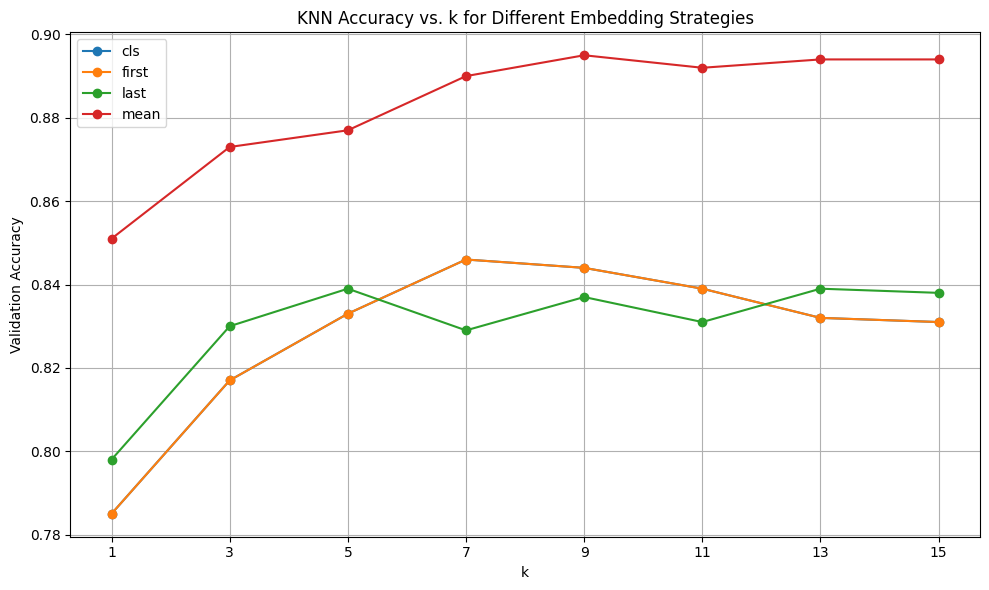

In [ ]:
# Plot KNN results
plt.figure(figsize=(10, 6))
for strategy in strategies:
    plt.plot(list(knn_results[strategy].keys()), list(knn_results[strategy].values()),
             marker='o', label=strategy)
plt.title('KNN Accuracy vs. k for Different Embedding Strategies')
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.xticks(list(knn_results[strategy].keys()))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

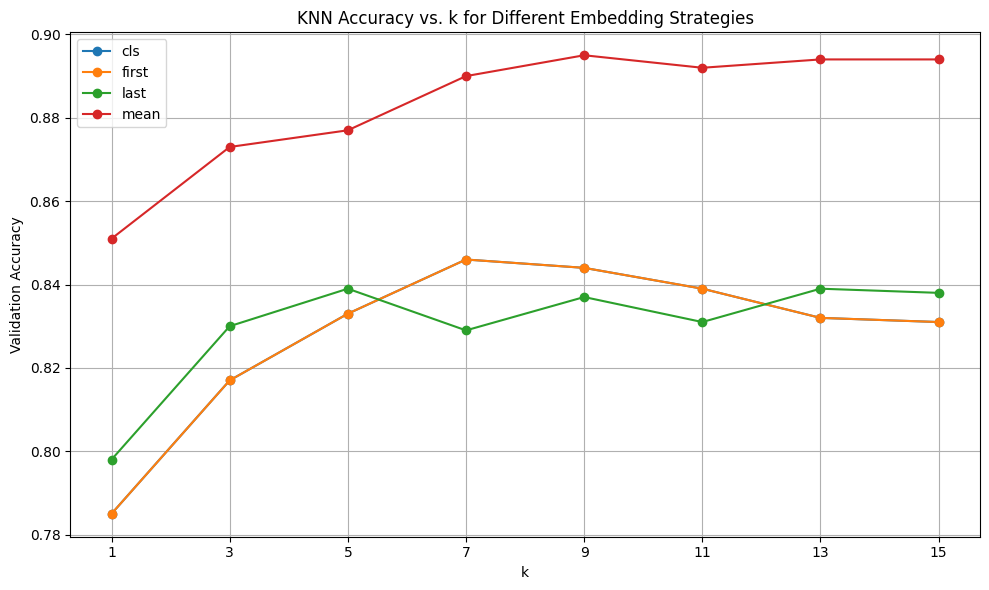

Note that CLS overlaps exactly with first, so we cannot seee its line

In [ ]:
# Evaluate logistic regression for different embedding strategies
print("\nEvaluating logistic regression with different embedding strategies...")
lr_results = {}

for strategy in strategies:
    print(f"\nEvaluating Logistic Regression with '{strategy}' embeddings:")
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(train_embeddings[strategy], train_val_labels_subset)
    val_preds = lr.predict(val_embeddings[strategy])
    accuracy = accuracy_score(val_labels[:1000], val_preds)
    lr_results[strategy] = accuracy
    print(f"Logistic Regression accuracy with '{strategy}' embeddings: {accuracy:.4f}")


Evaluating logistic regression with different embedding strategies...

Evaluating Logistic Regression with 'cls' embeddings:
Logistic Regression accuracy with 'cls' embeddings: 0.8690

Evaluating Logistic Regression with 'first' embeddings:
Logistic Regression accuracy with 'first' embeddings: 0.8690

Evaluating Logistic Regression with 'last' embeddings:
Logistic Regression accuracy with 'last' embeddings: 0.8730

Evaluating Logistic Regression with 'mean' embeddings:
Logistic Regression accuracy with 'mean' embeddings: 0.8960



Best embedding strategy for KNN: 'mean' with k=9 (accuracy: 0.8950)
Best embedding strategy for Logistic Regression: 'mean' (accuracy: 0.8960)


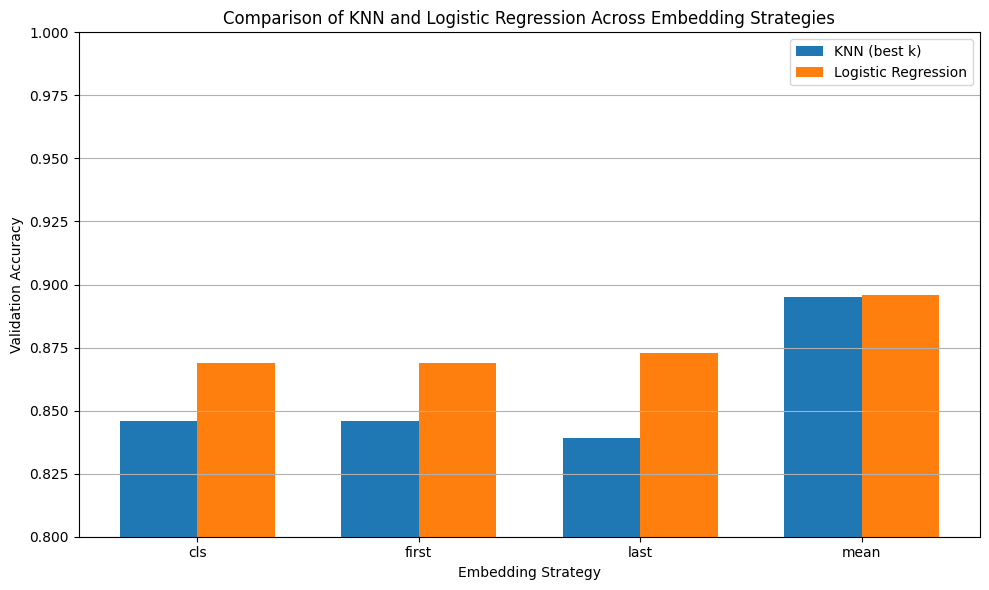

In [ ]:
# Determine best embedding strategy based on validation results
best_knn_strategy = max(best_accuracies, key=best_accuracies.get)
best_lr_strategy = max(lr_results, key=lr_results.get)

print(f"\nBest embedding strategy for KNN: '{best_knn_strategy}' with k={best_k_values[best_knn_strategy]} (accuracy: {best_accuracies[best_knn_strategy]:.4f})")
print(f"Best embedding strategy for Logistic Regression: '{best_lr_strategy}' (accuracy: {lr_results[best_lr_strategy]:.4f})")

# Compare KNN and Logistic Regression
plt.figure(figsize=(10, 6))
strategies_list = list(strategies)
knn_acc = [best_accuracies[s] for s in strategies_list]
lr_acc = [lr_results[s] for s in strategies_list]

x = np.arange(len(strategies_list))
width = 0.35

plt.bar(x - width/2, knn_acc, width, label=f'KNN (best k)')
plt.bar(x + width/2, lr_acc, width, label='Logistic Regression')

plt.title('Comparison of KNN and Logistic Regression Across Embedding Strategies')
plt.xlabel('Embedding Strategy')
plt.ylabel('Validation Accuracy')
plt.xticks(x, strategies_list)
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Based on the best embedding strategy, extract embeddings for test set
best_strategy = best_lr_strategy if lr_results[best_lr_strategy] > best_accuracies[best_knn_strategy] else best_knn_strategy
best_k = best_k_values[best_strategy]

print(f"\nBest overall strategy: '{best_strategy}'")
print(f"Extracting embeddings for test set using '{best_strategy}' strategy...")

test_texts = [example['text'] for example in test_dataset]
test_embeddings = extract_bert_embeddings(test_texts[:1000], best_strategy)  # Using subset for efficiency
print(f"Test embeddings shape: {test_embeddings.shape}")


Best overall strategy: 'mean'
Extracting embeddings for test set using 'mean' strategy...


Extracting BERT embeddings (mean): 100%|██████████| 1000/1000 [08:37<00:00,  1.93it/s]

Test embeddings shape: (1000, 768)


In [ ]:
# Train final KNN and Logistic Regression models on full training data
print("\nTraining final KNN and Logistic Regression models...")

# Train and evaluate KNN
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(train_embeddings[best_strategy], train_val_labels_subset)
knn_test_preds = final_knn.predict(test_embeddings)
knn_test_accuracy = accuracy_score(test_labels[:1000], knn_test_preds)
print(f"KNN test accuracy: {knn_test_accuracy:.4f}")

# Train and evaluate Logistic Regression
final_lr = LogisticRegression(max_iter=1000, random_state=42)
final_lr.fit(train_embeddings[best_strategy], train_val_labels_subset)
lr_test_preds = final_lr.predict(test_embeddings)
lr_test_accuracy = accuracy_score(test_labels[:1000], lr_test_preds)
print(f"Logistic Regression test accuracy: {lr_test_accuracy:.4f}")


Training final KNN and Logistic Regression models...


NameError: name 'KNeighborsClassifier' is not defined

## Task 3.2: BERT Fine-tuning

In [ ]:
# Create a PyTorch dataset for BERT fine-tuning
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Prepare datasets for fine-tuning
print("\nPreparing datasets for BERT fine-tuning...")
# Use a subset of training data for fine-tuning (as mentioned in the assignment)
finetune_size = 15000  # 15k examples as mentioned in the assignment
train_texts_finetune = train_val_texts[:finetune_size]
train_labels_finetune = train_val_labels[:finetune_size]

# Create PyTorch datasets
train_dataset_pt = AGNewsDataset(train_texts_finetune, train_labels_finetune, tokenizer)
val_dataset_pt = AGNewsDataset(val_texts, val_labels, tokenizer)
test_dataset_pt = AGNewsDataset(test_texts, test_labels, tokenizer)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset_pt, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_pt, batch_size=batch_size)
test_loader = DataLoader(test_dataset_pt, batch_size=batch_size)


Preparing datasets for BERT fine-tuning...


NameError: name 'test_texts' is not defined

In [ ]:
# Load pre-trained BERT model for sequence classification
print("Loading BERT for sequence classification...")
bert_classifier = BertForSequenceClassification.from_pretrained(
    "google-bert/bert-base-uncased",
    num_labels=4
)
bert_classifier.to(device)

Loading BERT for sequence classification...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Fine-tuning function
def fine_tune_bert(model, train_loader, val_loader, epochs=3):
    optimizer = AdamW(model.parameters(), lr=2e-5)
    best_val_accuracy = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['label']
            )

            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Evaluate on validation set
        val_accuracy = evaluate_bert(model, val_loader)
        val_accuracies.append(val_accuracy)
        print(f"Validation accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # Save model if needed
            # torch.save(model.state_dict(), "best_bert_model.pt")

    return train_losses, val_accuracies, best_val_accuracy

# Evaluation function
def evaluate_bert(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )

            _, predicted = torch.max(outputs.logits, 1)
            total += batch['label'].size(0)
            correct += (predicted == batch['label']).sum().item()

    return correct / total

In [ ]:
# Fine-tune BERT
print("\nFine-tuning BERT...")
train_losses, val_accuracies, best_val_accuracy = fine_tune_bert(bert_classifier, train_loader, val_loader, epochs=2)


Fine-tuning BERT...


Epoch 1/2:  37%|███▋      | 346/938 [1:59:43<3:20:03, 20.28s/it]

In [ ]:
# Plot training loss and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

## Task 3.3: Report classification performances

In [ ]:
# Evaluate fine-tuned BERT on test set
print("\nEvaluating fine-tuned BERT on test set...")
test_accuracy = evaluate_bert(bert_classifier, test_loader)
print(f"Fine-tuned BERT test accuracy: {test_accuracy:.4f}")

# Compare all methods on test set
methods = ['KNN', 'Logistic Regression', 'Fine-tuned BERT']
accuracies = [knn_test_accuracy, lr_test_accuracy, test_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies)
plt.title('Test Accuracy Comparison')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## Task 3.4: Attention Matrix Visualization

In [ ]:
# Get attention matrices for specific examples
def get_attention(model, tokenizer, text, layer=11):
    """Get attention scores for a text"""
    model.eval()

    # Tokenize the input
    tokens = tokenizer.tokenize(text)
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Truncate if needed
    max_tokens = 128  # Same as used in fine-tuning
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens-1] + ['[SEP]']

    # Convert tokens to IDs
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Create input tensors
    input_ids = torch.tensor([token_ids]).to(device)
    attention_mask = torch.ones_like(input_ids)

    # Get attention scores
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions

    # Extract attention from a specific layer
    attention = attentions[layer][0].cpu().numpy()

    return tokens, attention

In [ ]:
# Find correctly and incorrectly predicted examples
def find_examples(model, data_loader, num_correct=2, num_incorrect=2):
    model.eval()
    correct_examples = []
    incorrect_examples = []

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )

            _, predicted = torch.max(outputs.logits, 1)

            correct_mask = (predicted == batch['label'])
            incorrect_mask = ~correct_mask

            # Get indices of correct and incorrect predictions
            correct_indices = torch.where(correct_mask)[0]
            incorrect_indices = torch.where(incorrect_mask)[0]

            for idx in correct_indices:
                if len(correct_examples) < num_correct:
                    correct_examples.append({
                        'input_ids': batch['input_ids'][idx].cpu().numpy(),
                        'label': batch['label'][idx].item(),
                        'predicted': predicted[idx].item(),
                        'prob': torch.softmax(outputs.logits[idx], dim=0)[predicted[idx]].item()
                    })

            for idx in incorrect_indices:
                if len(incorrect_examples) < num_incorrect:
                    incorrect_examples.append({
                        'input_ids': batch['input_ids'][idx].cpu().numpy(),
                        'label': batch['label'][idx].item(),
                        'predicted': predicted[idx].item(),
                        'prob': torch.softmax(outputs.logits[idx], dim=0)[predicted[idx]].item()
                    })

            if len(correct_examples) >= num_correct and len(incorrect_examples) >= num_incorrect:
                break

    return correct_examples, incorrect_examples

print("\nFinding examples for attention visualization...")
correct_examples, incorrect_examples = find_examples(bert_classifier, test_loader)

In [ ]:
# Convert input IDs back to text
print("\nSelected examples:")
for i, example in enumerate(correct_examples):
    text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
    print(f"\nCorrectly predicted example {i+1}:")
    print(f"Text: {text}")
    print(f"True label: {label_names[example['label']]}")
    print(f"Predicted label: {label_names[example['predicted']]}")
    print(f"Confidence: {example['prob']:.4f}")

for i, example in enumerate(incorrect_examples):
    text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
    print(f"\nIncorrectly predicted example {i+1}:")
    print(f"Text: {text}")
    print(f"True label: {label_names[example['label']]}")
    print(f"Predicted label: {label_names[example['predicted']]}")
    print(f"Confidence: {example['prob']:.4f}")

In [ ]:
# Visualize attention matrices
def visualize_attention(model, tokenizer, text, layer=11, head=0):
    """Visualize attention for a specific layer and head"""
    tokens, attention = get_attention(model, tokenizer, text, layer)
    attention_head = attention[head]

    # Limit to first 30 tokens for better visualization
    if len(tokens) > 30:
        tokens = tokens[:30]
        attention_head = attention_head[:30, :30]

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_head, xticklabels=tokens, yticklabels=tokens, cmap="Blues")
    plt.title(f"Attention Matrix (Layer {layer+1}, Head {head+1})")
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize CLS token attention
def visualize_cls_attention(model, tokenizer, text, layer=11, head=0):
    """Visualize attention between CLS token and other tokens"""
    tokens, attention = get_attention(model, tokenizer, text, layer)
    attention_head = attention[head]

    # Get attention from CLS token to all other tokens
    cls_attention = attention_head[0]

    # Get top tokens by attention score (excluding CLS itself)
    if len(tokens) > 20:  # Limit visualization to top tokens
        indices = np.argsort(cls_attention[1:])[-19:]  # Get indices of top 19 tokens (plus CLS)
        indices = np.append([0], indices + 1)  # Add CLS token index and adjust indices
        tokens_selected = [tokens[i] for i in indices]
        cls_attention_selected = cls_attention[indices]
    else:
        tokens_selected = tokens
        cls_attention_selected = cls_attention

    # Create a horizontal bar plot
    plt.figure(figsize=(10, 8))
    plt.barh(tokens_selected, cls_attention_selected)
    plt.title(f"Attention from [CLS] token (Layer {layer+1}, Head {head+1})")
    plt.xlabel("Attention Score")
    plt.ylabel("Tokens")
    plt.tight_layout()
    plt.show()

In [ ]:
print("\nVisualizing attention matrices...")
# Visualize one correct and one incorrect example
if correct_examples:
    text = tokenizer.decode(correct_examples[0]['input_ids'], skip_special_tokens=True)
    layer = 11  # Last layer
    head = 0    # First attention head
    print(f"\nAttention matrix for correctly predicted example (Layer {layer+1}, Head {head+1}):")
    visualize_attention(bert_classifier, tokenizer, text, layer, head)
    print(f"\n[CLS] token attention for correctly predicted example:")
    visualize_cls_attention(bert_classifier, tokenizer, text, layer, head)

In [ ]:
if incorrect_examples:
    text = tokenizer.decode(incorrect_examples[0]['input_ids'], skip_special_tokens=True)
    print(f"\nAttention matrix for incorrectly predicted example (Layer {layer+1}, Head {head+1}):")
    visualize_attention(bert_classifier, tokenizer, text, layer, head)
    print(f"\n[CLS] token attention for incorrectly predicted example:")
    visualize_cls_attention(bert_classifier, tokenizer, text, layer, head)

## Summary of Results

In [ ]:
# Summary of results
print("\nSummary of classification results:")
print(f"KNN test accuracy: {knn_test_accuracy:.4f}")
print(f"Logistic Regression test accuracy: {lr_test_accuracy:.4f}")
print(f"Fine-tuned BERT test accuracy: {test_accuracy:.4f}")

print("\nBest embedding strategy for probing: ", best_strategy)
print(f"Best k for KNN: {best_k}")

print("\nComparison of probing vs. fine-tuning:")
probing_best = max(knn_test_accuracy, lr_test_accuracy)
improvement = test_accuracy - probing_best
print(f"Best probing accuracy: {probing_best:.4f}")
print(f"Fine-tuning accuracy: {test_accuracy:.4f}")
print(f"Improvement from fine-tuning: {improvement:.4f} ({improvement/probing_best*100:.2f}%)")